In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import utils

In [2]:
prefixes = [
    '../retrieval_outputs/no_bands_K_B_ret_7/test_', 
    '../retrieval_outputs/eq_band_K_B_ret_3/test_', 
    '../retrieval_outputs/spot_K_B_ret_23/test_', 
    ]

CCF_species = {
    'complete': [None]*len(prefixes), 
    'H2O':      ['H2O_pokazatel_main_iso']*len(prefixes), 
    'CO':       ['CO_main_iso']*len(prefixes), 
    #'CH4':      ['CH4_hargreaves_main_iso']*len(prefixes), 
    'CH4':      ['HF_main_iso']*len(prefixes),
    #'CO':       ['NH3_coles_main_iso']*len(prefixes), 
    #'CH4':      ['H2S_Sid_main_iso']*len(prefixes), 
    }

vsini = []; Rot = []

for i, prefix_i in enumerate(prefixes):

    Res_i = utils.RetrievalResults(prefix=prefix_i)

    for key_j, line_species_j in CCF_species.items():

        print(f'{key_j}')
        
        flux_global = None; subtract_global = False
        if line_species_j[i] is None:
            # Get the global model spectrum
            _, flux_global, Rot_i = Res_i.get_model_spec(is_local=False)
            subtract_global = True
        
        # Template spectrum of one species
        wave_local, flux_local, _ = Res_i.get_model_spec(
            is_local=True, line_species=line_species_j[i]
            )
        
        # Compute cross-correlation
        rv, _, CCF_SNR = Res_i.get_CCF(
            wave_local, flux_local, flux_global, 
            subtract_global=subtract_global, 
            #orders_to_include=[0]
            #high_pass={
            #    'm_res': utils.high_pass_filter(window_length=51), 
            #    #'d_res': utils.high_pass_filter(window_length=101), 
            #    }, 
            )
        CCF_species[key_j][i] = CCF_SNR

        del wave_local, flux_local, flux_global
    
    vsini.append(Res_i.bestfit_params['K2166_cloudy']['vsini'])
    Rot.append(Rot_i)
    del Res_i
    
    print()

  analysing data from ../retrieval_outputs/no_bands_K_B_ret_7/test_.txt
complete


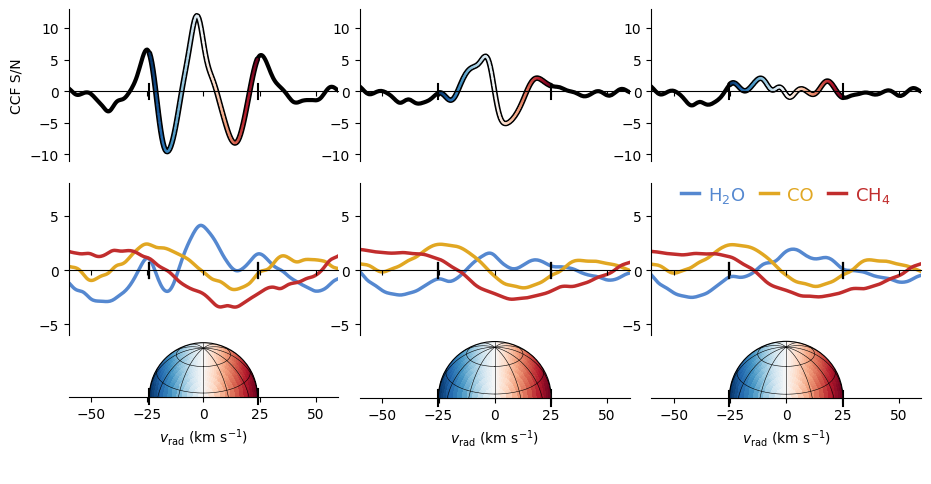

In [ ]:
fig = plt.figure(figsize=(11,6.5))
gs = fig.add_gridspec(nrows=3, ncols=3, hspace=0.15, wspace=0.08)
ax = []; ax_bottom = []
#ax_CCF = np.array([
#    fig.add_subplot(gs[0,0]), 
#    fig.add_subplot(gs[1,0]), 
#    ])
ylims = [(-11,13), (-6,8)]
xlim = (-60,60)
y_offset = 0.04
pad = np.array([-0.07,0.02,0.03,0.03])

colors = {'H2O': utils.get_color(3), 'CO': utils.get_color(4), 'CH4': utils.get_color(2)}
labels = {'H2O': r'H$_2$O', 'CO': r'CO', 'CH4': r'CH$_4$'}

for i, (Rot_i, vsini_i) in enumerate(zip(Rot, vsini)):

    for j, (key_j, CCF_j) in enumerate(CCF_species.items()):

        if j > 1:
            ax_j = ax[-1]
            ylim_j = ylims[1]
        else:
            ax_j = fig.add_subplot(gs[j,i])
            ylim_j = ylims[j]

            # Set x-axis to y=0
            ax_j.spines[['bottom']].set_position('zero')
            ax_j.spines[['bottom']].set_zorder(3)
            ax_j.set(xticks=np.arange(-100,101,25), xticklabels=[])

        ylabel = None
        if (i == 0) and (j == 0):
            ylabel='CCF S/N'

        # Plot the cross-correlation functions
        CC = utils.CrossCorrPlot(fig, ax_j, vsini=vsini_i)
        if j == 0:
            CC.plot(rv, CCF_j[i], lw=3, c='k', plot_colorbar=False, zorder=-1)
        else:
            CC.plot(
                rv, CCF_j[i], lw=2.5, c=colors[key_j], label=labels[key_j], 
                plot_multicolor=False, zorder=-1
                )

        CC.configure_ax(ylabel=ylabel, ylim=ylim_j, xlabel=None, xlim=xlim, plot_axvline=False)
        CC.add_xtick_at_vsini(length=0.1, c='k')

        ax.append(ax_j)

    # Plot the half-sphere at the bottom of the figure
    ax_bottom.append(fig.add_subplot(gs[2,i], projection='polar'))
    ax_bottom.append(fig.add_subplot(gs[2,i], zorder=-1))

    sphere = utils.SpherePlot(Rot_i, fig, ax_bottom[-2])
    sphere.plot_map(
        attr='v_grid', cmap='RdBu_r', edgecolors='face', lw=1e-6, 
        )
    sphere.configure_ax(
        xlim=(0,np.pi), sep_spine_lw=None, grid_lw=0.4
        )

    # Determine the vsini-width in one of the cross-correlation axes
    vsini_width, _ = np.diff(
        fig.transFigure.inverted().transform(
            ax[-1].transData.transform([(-vsini_i,0),(vsini_i,0)])
            ), 
        axis=0
        ).flatten()

    ax_bottom[-1].set(yticks=[], facecolor='none')
    ax_bottom[-1].spines[['left','top','right']].set_visible(False)
    ax_bottom[-1].spines[['bottom']].set_position('zero')

    # Change the width of the half-sphere axis
    l, b, w, h = ax_bottom[-2].get_position().bounds
    ax_bottom[-2].set_position([
        l+w/2-vsini_width/2, b+y_offset, vsini_width, h
        ])
    ax_bottom[-2].get_position() # Update

    # Shift the x-axis so it touches the half-sphere
    ylim = ax[-1].get_ylim()
    h = np.abs(ylim[1] - ylim[0])
    ax_bottom[-1].set(ylim=(-h/2,h/2))

    xy0 = fig.transFigure.inverted().transform(ax_bottom[-2].transData.transform((0,0)))
    xy1 = fig.transFigure.inverted().transform(ax_bottom[-1].transData.transform((0,0)))
    dy = xy0[1] - xy1[1]

    l, b, w, h = ax_bottom[-1].get_position().bounds
    ax_bottom[-1].set_position([
        l, b+dy, w, h
        ])

    CC = utils.CrossCorrPlot(fig, ax_bottom[-1], vsini=vsini_i)
    CC.plot(rv, CCF_species['CO'][i]*np.nan, plot_multicolor=False)
    CC.configure_ax(ylim=(-h/2,h/2), xlabel=None, plot_axvline=False)
    CC.add_xtick_at_vsini(length=0.1, c='k')

    ax_bottom[-1].set(
        xticks=np.arange(-100,101,25), xlim=ax[-1].get_xlim(),
        xlabel=r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$', 
        )

#ax[1].legend(
    #loc='upper left', bbox_to_anchor=(0,1.17), 
ax[-1].legend(
    #loc='upper left', bbox_to_anchor=(0,1.17), 
    loc='upper center', bbox_to_anchor=(0.5,1.1), ncol=3, columnspacing=0.8, 
    labelcolor=list(colors.values()), fontsize=13, frameon=False, 
    handlelength=1, labelspacing=0.3, handletextpad=0.5, 
)

# Create a tighter bounding box to save the figure
l, b, *_ = ax_bottom[1].get_position().bounds
r = ax_bottom[-1].get_position().bounds[0] + ax_bottom[-1].get_position().bounds[2]
t = ax[0].get_position().bounds[1] + ax[0].get_position().bounds[3]

l, r, b, t = np.array([l, r, b, t]) + pad

l, r = np.array([l, r]) * fig.get_size_inches()[0]
b, t = np.array([b, t]) * fig.get_size_inches()[1]
bbox = mpl.transforms.Bbox([[l,b],[r,t]])

plt.savefig('./plots/chem_cross_corr_all.pdf', bbox_inches=bbox)
plt.show()